### It is always recommended that you run a pilot acquisition using the testing sildes (bone and spongy bone) before proceeding with your samples.
### Jupyter Notebook basics
1. **Run a cell**. Click the blank area to the left of a cell to select the cell, hit `Shift+Enter`.  
2. **Insert a value**. Click on the location of a script will you want to insert characters.  
3. **Stop the execution process**. Click the stop button on the top menu bar of the notebook.  
4. **Restart the kernel**. Click the restart button on the top menu bar of the notebook. This usually fixes errors. After doing this, you need to re-run the cells from the beginning.  
5. `*` in front of a cell --> the cell is currently running.

## Imports

In [1]:
from pycromanager import Core, Studio
import imagej
from skimage import io as skio
import pickle
import os.path as path
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import yaml
from smartpath_libraries.sp_stitcher import SPStitcher
from smartpath_libraries.sp_acquisition import SPAcquisition
import scyjava
from IPython.utils import io as ipio

## Set maximum available memory for Java runtime
Increase this if the stitching fails.

In [2]:
scyjava.config.add_option('-Xmx16g') # 16 GB

## Initialize ImageJ and Pycro-Manager
Make sure Micro-Manager is running, with correct configuration file loaded. A backup of the configuration file can be found at `OpenScan-CAMM-cal.cfg`.     
The program is tested with `Micro-Manager-2.0_20220613`, PyImageJ `1.2.1`, Pycro-manager `0.18.0`, PyTotrch `1.12.1`, QuPath `0.3.2`, and OpenScan (compiled files with Micro-Manager can be found [here](https://drive.google.com/file/d/1e_Q311syAD0qYl1GpRtoCkQdJnyjRh4i/view?usp=sharing))  
Other ways of loading different versions of ImageJ via PyImageJ can be found in [PyImageJ examples](https://github.com/imagej/pyimagej).   
Expected output: 
```
ImageJ version: xxx
<pycromanager.core.mmcorej_CMMCore object at xxxxxxxx>
```
If you re-run this cell in the same session, you will get an error. You can re-run this cell after the kernel is restarted (meaning you have clicked the restart button on the top menu bar of the notebook).

In [3]:
wdir = os.getcwd()
core = Core()
studio = Studio()
ij = imagej.init('sc.fiji:fiji:2.1.0', mode='headless') # Load ImageJ, https://github.com/imagej/pyimagej
print(f"ImageJ version: {ij.getVersion()}")
core.set_timeout_ms(20000)
print(core)
os.chdir(wdir)

ImageJ version: 2.1.0/1.53c


## Read configuration file
You can open `config.yaml` to change settings. But usually, it is necessary only if the system is recalibrated.   
Expected output: 
```
{ 'xxx' : xxx
}
```

In [4]:
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config['user_config'], **config['model_config'], **config['hard_config']}
lsm_pixel_size_base = config['pixel-size-shg-base']
bf_4x_pixel_size_base = config['pixel-size-bf-4x']
bf_20x_pixel_size_base = config['pixel-size-bf-20x']
camera_resolution_base = config['camera-resolution']
config

{'exposure-level': 'high',
 'snr-level': 'low',
 'autofocus-speed': 3,
 'lsm-resolution': 256,
 'lsm-bin-factor': 15,
 'lsm-scan-rate': '250000.0000',
 'lsm-pc-power': 0.4,
 'lsm-pmt-gain': 0.4,
 'slide-box': [-100, 600, 25500.0, 17000.0],
 'lsm-enhancer': None,
 'bf-enhancer': None,
 'classifier': None,
 'adv-interval': 3,
 'average-factor': 50,
 'batch-size': 8,
 'blindspot-rate': 0.05,
 'cnn-base-channel': 8,
 'dataset': 'datasets/PA_2081b',
 'gan-lambda': 5,
 'gpu': True,
 'image-channel': 1,
 'image-extension': 'tif',
 'iter-per-epoch': 200,
 'iterations': 200000,
 'learning-rate': 0.0001,
 'load-weights': 'supervised2022-08-07_13-02-52',
 'loss-gain': 1000,
 'norm-range': [5420, 44017],
 'norm-range-target': [6265, 38567],
 'only-pixel-loss': False,
 'percep-lambda': 0.5,
 'resolution': 512,
 'test-interval': 5,
 'threads': 0,
 'up-scale-factor': 2,
 'pixel-size-bf-20x': 0.222,
 'pixel-size-bf-4x': 1.105,
 'pixel-size-shg-base': 0.509,
 'pixel-size-shg': 0.509,
 'camera-resolutio

## Initialize scanner and stitcher object
Here you should set the `acq_name` variable. No Spaces in name! Use - or _ No `ome` in name! The acquisition data will be saved inside `data/acquisition` folder.  
The variable `slide_box` needs to be set to roughly cover the area of the slide. The default value is `[-1000, 2000, 26000, 24000]` which covers the whole slide area on CAMM. The format is `[x stage start, x stage end, y stage start, y stage end]`. The values can be read out at 4x brightfield mode from the Micro-Manager GUI **Stage->(first icon)** when you find the corners of the bounding box of the area.  
You can also use other brightfield background images instead of the defaults. Capture a background image via Micro-Manager GUI **Snape** and save it. Then set the path to the image file to `brightfield_background_fname` variables.  
Expected output: 
```
Load LSM preset.
[4x background image, 20x background image]
```

Load LSM presets.


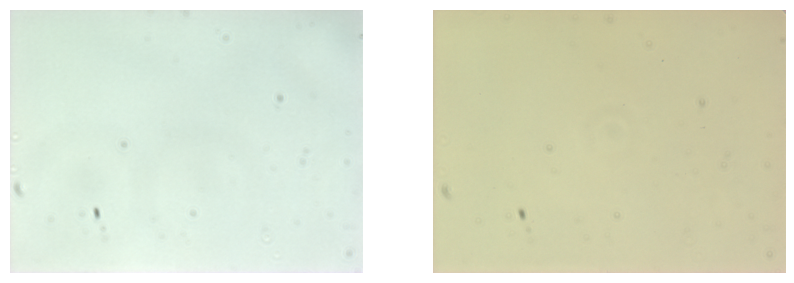

In [5]:
### User configuration block

save_path = 'data/acquisition'

acq_name = 'PA2081b_0913' # No Spaces in name! Use - or _ No `ome` in name!

slide_box = [-1000, 2000, 26000, 24000]
brightfield_4x_background_fname = 'data/presets/BG_4x.tiff' # give a default 4x background image
brightfield_20x_background_fname = 'data/presets/BG_20x.tiff' # give a default 20x background image
bfbg_4x = skio.imread(brightfield_4x_background_fname)
bfbg_20x = skio.imread(brightfield_20x_background_fname)
qupath_fname = os.path.join('QuPath-0.3.2', 'QuPath-0.3.2.exe') # QuPath executable, os.sep does matter!!!

sp_acq = SPAcquisition(
    config=config,
    mmcore=core, 
    mmstudio=studio,
    bf_4x_bg=skio.imread(brightfield_4x_background_fname), 
    bf_20x_bg=skio.imread(brightfield_20x_background_fname), 
    )

sp_sti = SPStitcher(
    config=config, 
    ij=ij,
    working_dir=save_path,
    qupath_dir=qupath_fname, 
    )

sp_acq.update_slide_box(slide_box)
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x

_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(bfbg_4x, label='4x background'), ax[1].imshow(bfbg_20x), ax[0].axis('off'), ax[1].axis('off')
plt.show()

### Brightfield run-time processor (optional, recommended)
This cell configures a run-time downsampler (factor of 2) for brightfield images. It makes the output brightfield image files much smaller with very minimum reduction in the actual image details.  

In [6]:
### Rescale the image (optional)
from skimage.transform import rescale
downsampler = lambda x: rescale(x, 0.5, order=1, channel_axis=-1)
sp_acq.bf_process_fn = downsampler
# pixel size will change
sp_acq.config['pixel-size-bf-4x'] = bf_4x_pixel_size_base * 2
sp_acq.config['pixel-size-bf-4x'] = bf_4x_pixel_size_base * 2
sp_acq.config['camera-resolution'] = [int(camera_resolution_base[0]/2), int(camera_resolution_base[1]/2)]
sp_sti.config['pixel-size-bf-20x'] = bf_20x_pixel_size_base * 2
sp_sti.config['pixel-size-bf-20x'] = bf_20x_pixel_size_base * 2

## 4x acquisition
If you are trying to resume a session where the 4x collection is finished, you need to run the next cell and then can go straight to 20x acquisition. The same 4x scan name must be used to resume a session.

### Set objective and modality
After the 4x mode is set, you can use the next cell or Micro-Manager GUI **Live** for inspection. You can move the stage, find coordinates of the bounding box of the tissue area, and adjust `slide_box` variable in the previous cell, if necessary.  
This cell needs to be executed in order to resume an interupted session. The same 4x scan name must be used to resume a session.  
Expected output:
```
Imaging objective set as 4x
Imaging objective set as 4x
Imaging mode set as Brightfield
```

In [7]:
acq_name_4x = acq_name + '-4x-bf' 
sp_acq.switch_objective(mag='4x')
sp_acq.switch_mod(mod='bf')

Imaging objective set as 4x
Imaging objective set as 4x
Imaging mode set as Brightfield


### Focus on the sample
Focus on the sample using the stage controller or using the stage control panel from Micro-Manager.   
**Click the stop button (top menu bar of the notebook, black square)** after done to stop live view.

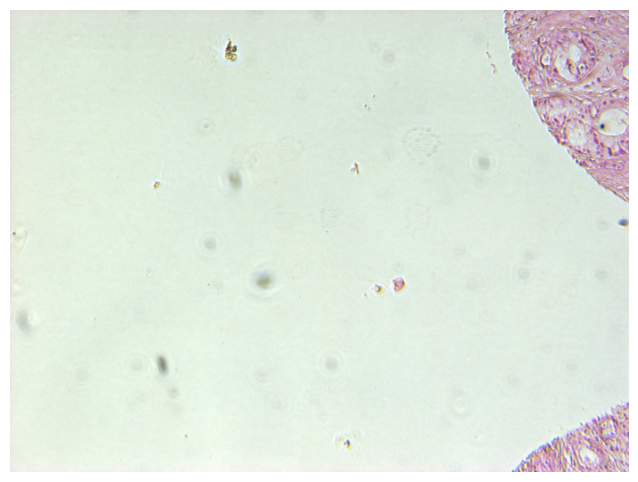

In [8]:
last_img = sp_acq.live(mod='bf', flip_channel=True)

Run the following cell to update the focus preset to the configuration file.

In [9]:
sp_acq.update_focus_presets(mag='4x', mod='bf') # update focus preset

### Change autofocusing speed (optional)
`1-6`, the larger the faster, but potentially worse autofocusing resuls.

In [10]:
sp_acq.config['autofocus-speed'] = 4 # default is 4

### Perform the scan
Make sure no live view is running in Micro-Manager. You can check the acquired tiles at `data/acquisition/acq_name`.   
**How to stop the acquisition** You can stop the acquisition at anytime by clicking the stop button on the top menu.  
If you have too many unsuccessful attempts with the same `acq_name` (more than 10 times), remove the image folders `data/acquisition/acq_name_[ID]`.  
The tiles will be automatically stitched once the acquistion is done (the `*` sign to the top left of the cell is relaced with a number). The stitched image wil be saved at `data/slides/4x`.  
**Trouble shooting**:
1. First several images are not in focused. --> Stop the acquisition, focus on the sample again and re-run the cell that update the focus presets.  
2. Some images in the middle are not in focused. --> Stop the acquisition, reduce the autofocusing speed.  
3. Images in focused, but color looks off. --> Acquire a new background image, and set the path to `brightfield_4x_background_fname` variable, re-run from that cell.
4. Error out with java types messages. --> Close (or stop) any live view running in Micro-Manager. 
5. Memory related error messages. --> Increase maximum available memory size for Java run-time.  

In [11]:
### perform the scan
sp_acq.switch_objective(mag='4x')
sp_acq.switch_mod(mod='bf')
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x
results_4x = sp_acq.whole_slide_bf_scan(
    save_path, 
    acq_name_4x, 
    position_list_4x.reshape(position_list_4x.shape[0]*position_list_4x.shape[1], -1), 
    mag='4x',
    focus_dive=True,
    estimate_background=False,
    )
### save background image and z positions, and position_list
results_4x['Position list'] = position_list_4x
sp_acq.z_list_4x = results_4x['Z positions']
with open(path.join(save_path, acq_name_4x+'.pkl'), 'wb') as f:
    pickle.dump(results_4x, f)

### perform the stitching
position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
with ipio.capture_output() as captured:
    sp_sti.stitch_bf(
        acq_name_4x,
        mag='4x',
        position_list=position_list,
        flip_y=True,
        correction=False, # this should be set `True` if the default background image was not given during the acquisition
        background_image=None # this should be given as `loaded_results_4x['Background image']` `correction` is `True`
        )
sp_sti.convert_slide(mag='4x')
### optional clean the intermediate stitching files
sp_sti.clean_folders(acq_name_4x)

100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [10:16<00:00,  1.63s/it]

 378/378 tiles done

Converting slide to ome.tif
[4,2.21]


## Draw annotations using QuPath
You can find the instructions [here](https://docs.google.com/document/d/1bNAhTBUaounlFZqjYNVf6zONRItLhQPYPVLXFLlFEpU/edit?usp=sharing).  
Before proceeding, make sure position lists are successfully saved in `qupath-projects/mp-tiles/` and `qupath-projects/20x-tiles/`. The file names should start with something like `[acq_name]-4x-bf-[ROI_name]`.

## 20x acquisition
If you are trying to resume a session where all 20x brightfield images have already been collected, you can skip the collection and go straight to SHG acquisition.

### Set objective and modality

In [8]:
sp_acq.switch_mod(mod='bf') 
sp_acq.switch_objective(mag='20x')

Imaging objective set as 4x
Imaging mode set as Brightfield
Imaging objective set as 20x


### Focus on the sample
Follow the same steps for 4x brightfield acquisition

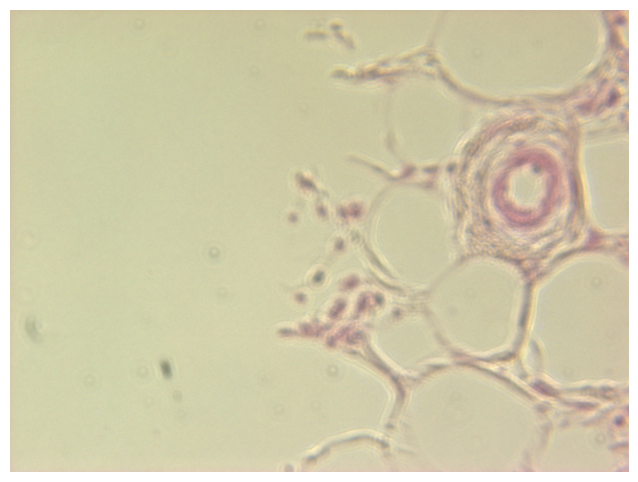

In [9]:
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [10]:
sp_acq.update_focus_presets(mag='20x', mod='bf')

In [11]:
sp_acq.config["autofocus-speed"] = 4 

### Perform the scan
Follow the same steps for 4x brightfield acquisition.  
If you need to set a new background image, set the path of the background image to `brightfield_20x_background_fname` variable.  
Individual ROIs are saved at `data/slides/20x`.  

In [19]:
### load 4x results from disk
sp_acq.switch_mod(mod='bf') 
sp_acq.switch_objective(mag='20x')
with open(path.join(save_path, acq_name_4x+'.pkl'), 'rb') as f:
    loaded_results_4x = pickle.load(f)
sp_acq.position_list_4x = loaded_results_4x['Position list']
sp_acq.z_list_4x = loaded_results_4x['Z positions']
position_list_xyz = np.concatenate((   
    sp_acq.position_list_4x, 
    sp_acq.z_list_4x.reshape((sp_acq.position_list_4x.shape[0], sp_acq.position_list_4x.shape[1], 1))
    ), 2)
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
position_lists_20x, annotation_names = zip(*sorted(zip(position_lists_20x, annotation_names), key=lambda x: int(x[1].split('-')[-1])))
### perform the scan
sp_acq.position_list_20x = []
sp_acq.z_list_20x = []
for idx, (roi_pos, roi_name) in tqdm(enumerate(zip(position_lists_20x, annotation_names))):
    current_acq_name = acq_name + '-20x-' + annotation_names[idx]
    sampled_pos_xyz = sp_acq.resample_z_pos(mag='20x', xy_pos=roi_pos, xyz_pos_list_4x=position_list_xyz)
    results_20x = sp_acq.whole_slide_bf_scan(
        save_path, 
        current_acq_name, 
        sampled_pos_xyz, 
        mag='20x',
        focus_dive=True,
        estimate_background=False,
        )
    sp_acq.position_list_20x.append(sampled_pos_xyz)
    sp_acq.z_list_20x.append(results_20x['Z positions'])
    sp_acq.config['Z-stage-20x'] = np.mean(np.vstack(sp_acq.z_list_20x))
    ### save background image and z positions, and position_list
    position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
    with ipio.capture_output() as captured:
        sp_sti.stitch_bf(
            current_acq_name,
            mag='20x',
            position_list=sampled_pos_xyz,
            flip_y=True,
            correction=False, 
            background_image=None 
            )
    sp_sti.convert_slide(mag='20x')
    # while True:
    #     try: 
    #         sp_sti.clean_folders(current_acq_name) # optional
    #         break
    #     except: continue
np.save(os.path.join(save_path, acq_name +'-20x'+'-z_pos.npy'), sp_acq.z_list_20x, allow_pickle=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:04<00:00,  2.14s/it]

 30/30 tiles done

Converting slide to ome.tif


C:\Users\lociuser\Miniconda3\envs\pyimagej\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Perform SHG scan

### Change SHG scan settings
Available values:
```
"lsm-scan-rate" : '50000.0000', '100000.0000', '125000.0000', '200000.0000', '250000.0000', '400000.0000', 
    '500000.0000', '625000.0000', '1000000.0000', '12500000.0000', default is '100000.0000' or '500000.0000'. This is a (string), not (int). '.0000' is necessary.
"lsm-pc-power" : 0-0.7, default is 0.5
"lsm-pmt-gain" : 0-0.8, default is 0.7
"lsm-resolution" : 256, 512, 1024, default is 512 or 256
```
This cell and the next cell need to be executed to successfully update the parameters. 

In [25]:
sp_acq.config["lsm-scan-rate"] = '200000.0000' # slow: '100000.0000'; fast: '500000.0000'
sp_acq.config["lsm-pc-power"] = 0.5 # max 0.8
sp_acq.config["lsm-pmt-gain"] = 0.7 # max 0.8 
sp_acq.config["lsm-resolution"] = 512 # slow: 512; fast: 256
sp_acq.config_preset(sp_acq.config)
sp_sti.config = sp_acq.config
sp_sti.config["pixel-size-shg"] = lsm_pixel_size_base
sample_depth = 21 
z_step = 7 
sp_acq.dump_configuration(acq_name)
sp_acq.core.set_property('OSc-LSM', 'PXI2Slot2-GalvoOffsetX (degree)', 0.0) # (optional) Adjustment to match FOV of different settings, use 0.45 for fast setting, use 0.0 for slow setting,

### Set objective and modality
It is necessary to reset the modality if the scanning parameters are changed. 

In [26]:
sp_acq.switch_objective(mag='20x')
sp_acq.switch_mod(mod='shg')

Imaging objective set as 20x
Imaging mode set as SHG


### Enable a run-time processer for the LSM acquisition (optional)
The whole subsection is optional.

In [22]:
### Median filter for example
from skimage.filters import median
from skimage.morphology import diamond
func = lambda image: median(image, footprint=diamond(1))
# func = lambda image: image # just pass the image witout processing
sp_acq.define_lsm_processor(func)

In [10]:
### A wavelet denoiser
from skimage.restoration import denoise_wavelet
def func(image):
    denoised = denoise_wavelet(image, rescale_sigma=True)
    return denoised
sp_acq.define_lsm_processor(func)

In [28]:
### A total varition-based denoiser
from skimage.restoration import denoise_tv_chambolle
def func(image):
    denoised = denoise_tv_chambolle(image, weight=0.005)
    return denoised
sp_acq.define_lsm_processor(func)

In [25]:
### Deep neural networks (2x upscale)
from smartpath_libraries.enhancer import Enhancer
import torch
model_config = config
enhancer = Enhancer(model_config, scale_factor=model_config['up-scale-factor'], perceptual_loss=True, adversarial_loss=True)
enhancer.backbone.load_state_dict(torch.load(os.path.join('weights', 'enhancer.pth')))
sp_acq.lsm_enhancer = enhancer
sp_acq.define_lsm_processor(network=True)
# The pixel size for SHG will change if the images are upscaled.
sp_sti.config["pixel-size-shg"] = lsm_pixel_size_base / 2

To disable any run-time processing function, you can specify a function that simply passes the image, like the one below.

In [23]:
# Or just pass the image witout processing
func = lambda image: image 
sp_acq.define_lsm_processor(func)

### Perform the scan

You can skip first N ROIs, setting the `skip_roi_id` varible to `N` will skip the first N ROIs. Setting it to `0` will start from the first ROIs.  
Once the acquisition starts, a Micro-Manager image display window will pop up after first image is collected. Adjust the histogram to view the image with better contrast if necessary.  
Individual ROIs are saved at `data/slides/mp`.  
**How to stop the acquisition** You can stop the acquisition at anytime. First, click the stop button on the Micro-Manager image display window, and click the stop button on the top menu bar of the notebook.  
**Trouble shooting**  
1. Repeatly says "PMT overloaded!" --> The PMT is off or your signal is too bright. Reduce PMT gain.  
2. It won't stop. --> Click the stop button multiple times, or click restart button (also on the top menu bar of the notebook). If the kernel is restarted, you will have to run from the beginning and resume the session by running some necessary cells.
3. No signal. --> The current FOV does not contain detectable structures, or the PMT is off, or the laser shutter is off, or the laser modelock is off. Check the hardware setup section of this [guide](https://docs.google.com/document/d/1mAJuh3Eu8Bkt_IAWVCzh7XT79KacVCjf/edit?usp=sharing&ouid=111512958445591507194&rtpof=true&sd=true). 

In [23]:
skip_roi_id = 0

In [29]:
core.set_auto_shutter(False)
position_lists_mp, annotation_mp = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='mp')
position_lists_mp, annotation_mp = zip(*sorted(zip(position_lists_mp, annotation_mp), key=lambda x: int(x[1].split('-')[-1])))
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
position_lists_20x, annotation_names = zip(*sorted(zip(position_lists_20x, annotation_names), key=lambda x: int(x[1].split('-')[-1])))
return_20x_list = np.load(os.path.join(save_path, acq_name+'-20x'+'-z_pos.npy'), allow_pickle=True).tolist()
return_20x_list = np.vstack(return_20x_list)
map_xyz_20x = np.concatenate((np.vstack(position_lists_20x), return_20x_list.reshape((return_20x_list.shape[0], 1))), 1)
sp_acq.lsm_reset_PMT()
for idx, (roi_pos, roi_name) in enumerate(zip(position_lists_mp, annotation_mp)):
    if idx < skip_roi_id: continue
    sp_acq.switch_objective(mag='20x')
    sp_acq.switch_mod(mod='shg')
    current_acq_name = acq_name + '-lsm-truth-' + roi_name
    # roi_pos[:, 0] = roi_pos[:, 0] #- 2907
    # roi_pos[:, 1] = roi_pos[:, 1] #+ 3183 
    sampled_pos_xyz_mp = sp_acq.resample_z_pos(mag='mp', xy_pos=roi_pos, xyz_pos_list_20x=map_xyz_20x)
    sp_acq.whole_slide_lsm_scan(
        save_path, 
        acq_name=current_acq_name, 
        position_list=sampled_pos_xyz_mp, 
        z_stack=True, 
        sample_depth=sample_depth, 
        z_step=z_step
        )
    num_channel = int(sample_depth/z_step)+1
    with ipio.capture_output() as captured:
        sp_sti.stitch_lsm(
            save_path, 
            current_acq_name, 
            n_stack=3, # just keep it as 3, the actual number of stacks can be different 
            position_list=sampled_pos_xyz_mp, 
            flip_y=False, 
            rotate=270
            )
        sp_sti.convert_slide(mag='mp')
        # sp_sti.clean_folders(current_acq_name)

Imaging objective set as 20x
Imaging mode set as SHG
Imaging objective set as 20x
Imaging mode set as SHG
Imaging objective set as 20x
Imaging mode set as SHG


### Take away your data in `data/acquisition` folder!  
### You can also find a copy of your configuration file in `acquisition-configs` folder.

In [6]:
user_config = {
    
    ### User configuration ###
    
    # Quick configuration group for LSM
    "exposure-level" : 'high',
    # 'low'     -> scan rate: '500000.0000', pockel cell gain: 0.30, PMT gain: 0.40
    # 'mid'     -> scan rate: '400000.0000', pockel cell gain: 0.45, PMT gain: 0.45
    # 'high'    -> scan rate: '250000.0000', pockel cell gain: 0.60, PMT gain: 0.50
    # 'extreme' -> scan rate: '200000.0000', pockel cell gain: 0.75, PMT gain: 0.55
    
    "snr-level" : 'low',
    # Estimiated correction according to sample SNR level. Available value: 'low', 'mid', 'high', by default raw data is collected
    
    "autofocus-speed" : 3,
    # Speed of software autofocus, integer: 1~5. Bigger value leads to faster brightfield scan but potentially lower autofocus performance
       
    "lsm-resolution" : 256, 
    # LSM scan resolution, available resolution: 256, 512, 1024
    
    "lsm-bin-factor" : 15,
    # LSM scan pixel average factor, positive integer
    
    "lsm-scan-rate" : '250000.0000', 
    # LSM scan rate, available value (string): '125000.0000', '200000.0000', '250000.0000','400000.0000', '500000.0000', '625000.0000', '1000000.0000'
    
    "lsm-pc-power" : 0.4, 
    # LSM pockel cell gain, float point value: 0.0 ~ 1.0
    
    "lsm-pmt-gain" : 0.4,
    # LSM PMT gain, float point value: 0.0 ~ 1.0
    
    "slide-box" : (-100, 600, 25500.0, 17000.0), 
    # Pre-define scan area (read out values from the stage): (start x stage position, start y stage position, end x stage position, end y stage position)
    
    "lsm-enhancer" : None,
    
    "bf-enhancer" : None,
    
    "classifier" : None,
    # Automatic target detection model, available value (string or None): 'MIL', 'Supervised', None 
    
}

model_config = {
    
    "gpu" : False,
    # Is GPU available? Available value (boolean): True, False
    
    "batch-size" : 32,
    # Is GPU available? Available value (boolean): True, False 
    
    ### configure enhancer ###
    
    "image-channel" : 1,
    
    "dropout-rate" : 0.1, 
    
    "cnn-base-channel" : 4,
    
    "normalization" : None,
    # CNN normalization layere type
    
    "norm-range" : (13251, 63085),
    # Image normalization range, determined via *_dataset_preprocessing.ipynb in lsm-run-time-enhancement repo
         
    
    "dimension" : '2D',
    
    ### configure classifier
    
    "classifier-backbone" : 'ResNet18',
    # Backbone for CNN model, available value (string): 'ResNet18', 'ResNet34' 
    
    "classifier-num-class" : 2,
    # Number of class for the detector, non-zero integer
    
    "mil-classifier-thresh" : 2,
    # Threshold for MIL classifier. Obtained from training.
    
    "slide-type" : 'TMA',
    # Type of image the inference is applied, available value (string): "TMA", "slide"      

}

### right general save range check function
hard_config = {
    ### Hard configuration, 
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg-base" : 0.509, # 0.509 micron/pixel at 256
    "pixel-size-shg" : 0.509,
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),
    "slide-size" : (40000.0, 20000.0), # (width, height) (70000, -20000)
#     "Z-stage-20x" : -6930, # -6930 + 290 / 10500
    "Z-stage-20x" : -6980, # -6930 + 290 / 10500
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15800, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "Z-bf-offset" : -10500,
    "Z-laser-offset" : 290,
    "hard-limit-z" : (-8500.0, 17000.0),
    "hard-limit-x" : (-5000.0, 40000.0),
    "hard-limit-y" : (-4200, 25000.0), #(-2200, 19000.0)
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-600, 10), # 4x + this value to 20x // (-590, 74)
    "shg-offset" : (-580, -280), # 4x + this value to shg // (-580, -172)
    "led-4x" : 4,
    "led-20x" : 5,
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}